# Deploy Image Classification with OpenVINO Model Server in OpenShift 

We will show you how to deploy OpenVINO Model Server (OVMS) in an OpenShift cluster and how to run a gRPC prediction request to the AI inference service.

Requirements:
- OpenShift cluster with the API access to a project
- installed [OpenVINO Model Server Operator](https://catalog.redhat.com/software/operators/search?q=openvino)
- JupyterLab environment with Python3 deployed in the cluster

If you don't have an OpenShift account, you can sign up for 30 or 60 day [free trial of Red Hat OpenShift](https://www.openshift.com/try).

## Login to OpenShift with API Token

First, let's login to OpenShift cluster using `oc` tool. 

In the Red Hat OpenShift console, click on your username and select `Copy login command`.

![copy-login.png](notebook-files/copy-login.png)

Click on `Display Token` and your API token will appear.

![log-in-with-token.png](notebook-files/log-in-with-token.png)

Copy `Log in with token` command and paste it in the cell below. The command has your `<user-API-token>` and `<cluster-DNS-name>`.

In [ ]:
!oc login --token=<user-API-token> --server=https://api.<cluster-DNS-name>:6443

Create `ovms` project and go to this project.

In [ ]:
!oc new-project ovms
!oc project ovms

In [ ]:
textureNet/textureNet.onnx 

## Create MinIO Storage

OpenVINO Model Server exposes DL models over gRPC and REST interface. The models can be stored in cloud storage like AWS S3, Google Storage or Azure Blobs. In OpenShift and Kubernetes, Persistent Storage Claim could be used as well. In this tutorial, we will use MinIO service which is an equivalent of AWS S3.

Let's create a MinIO service.

In [16]:
!oc apply -f minio.yaml

deployment.apps/minio unchanged
service/minio-service unchanged


Next step is to download `mc`, MinIO Client.

In [17]:
!wget https://dl.min.io/client/mc/release/linux-amd64/mc

--2021-05-05 18:03:22--  https://dl.min.io/client/mc/release/linux-amd64/mc
Resolving dl.min.io (dl.min.io)... 178.128.69.202
Connecting to dl.min.io (dl.min.io)|178.128.69.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20529152 (20M) [application/octet-stream]
Saving to: ‘mc’

mc                  100%[===================>]  19.58M  14.5MB/s    in 1.3s    

2021-05-05 18:03:24 (14.5 MB/s) - ‘mc’ saved [20529152/20529152]



Change the access permissions on `mc`, so we can run commands with it.

In [18]:
!chmod 755 mc

Let's make an alias for the MinIO service.

In [19]:
!./mc alias set minio http://minio-service.ovms:9000 minio minio123

Added `minio` successfully.


Create a `minio/models` bucket; it's where we will store our model.

In [20]:
!./mc mb minio/models

mc: <ERROR> Unable to make bucket `minio/models`. Your previous request to create the named bucket succeeded and you already own it.


## Create ResNet Model Repository

Now, we will upload the models for serving in the OpenVINO Model Server. We will use [ResNet50 model in ONNX format](https://github.com/onnx/models/tree/master/vision/classification/resnet).


Now, copy the ResNet model into MinIO bucket.

In [37]:
!./mc cp --recursive textureNet minio/models/

...eNet.onnx:  1.06 MiB / 1.06 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 100.65 MiB/s 0s

Let's make sure the model has been successfully copied.

In [40]:
!./mc ls -r minio/models/textureNet

[2021-05-05 19:32:04 UTC] 1.1MiB 1/textureNet.onnx


## Deploy OpenVINO Model Server

Let's deploy an OpenVINO Model Server service in the cluster. We will create a serving of a single model, ResNet50 model in ONNX format, which we uploaded into MinIO bucket.

Here's the yaml file used to configure the OVMS service. We specified name to be `ovms-resnet` and `model_path` to be `s3://minio-service:9000/models/resnet`. Also, we defined `model_name` here.

In [41]:
!cat ovms-salt.yaml

apiVersion: intel.com/v1alpha1
kind: Ovms
metadata:
  name: ovms-salt
spec:
  aws_access_key_id: "minio"
  aws_region: "us-east-1"
  aws_secret_access_key: "minio123"
  grpc_port: 8080
  image_name: registry.connect.redhat.com/intel/openvino-model-server:latest
  log_level: INFO
  model_name: "textureNet"
  model_path: "s3://minio-service:9000/models/textureNet"
  plugin_config: '{\"CPU_THROUGHPUT_STREAMS\":\"1\"}'
  replicas: 1
  resources:
    limits:
      cpu: 4
      memory: 500Mi
  rest_port: 8081
  service_type: ClusterIP


Run the cell below to create new OVMS service called `ovms-salt`.

In [49]:
!oc apply -f ovms-salt.yaml

ovms.intel.com/ovms-salt created


Let's see if pod and service were created. They should start with `ovms-salt`.

In [50]:
!oc get pod
!oc get service

NAME                             READY     STATUS        RESTARTS   AGE
minio-5c57f888dd-llr4k           1/1       Running       0          10h
ovms-pipeline-66494fbd96-q7crc   1/1       Running       0          3h5m
ovms-resnet-6b5bddd696-25n9n     0/1       Terminating   0          10h
ovms-salt-7f9c79469-2882c        0/1       Running       0          8s
NAME            TYPE        CLUSTER-IP       EXTERNAL-IP   PORT(S)             AGE
minio-service   ClusterIP   172.30.49.127    <none>        9000/TCP            10h
ovms-pipeline   ClusterIP   172.30.161.138   <none>        8080/TCP,8081/TCP   3h5m
ovms-salt       ClusterIP   172.30.234.208   <none>        8080/TCP,8081/TCP   9s


Let's check if the OpenVINO Model Server service is running by making an API request via cURL.

In [68]:
!curl http://ovms-salt.ovms.svc:8081/v1/models/textureNet

E0505 21:32:33.396736952    3605 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1620250353.396632666","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1620250353.396631187","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":948,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": "OK"
   }
  }
 ]
}


In [73]:
!pip install tqdm scipy pyvista PVGeo ipyml

     |████████████████████████████████| 1.2 MB 35.4 MB/s eta 0:00:01
     |████████████████████████████████| 107 kB 111.8 MB/s eta 0:00:01
     |████████████████████████████████| 103.4 MB 93.7 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 71.4 MB/s  eta 0:00:01
     |████████████████████████████████| 153 kB 87.1 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 43.9 MB/s eta 0:00:01
  Created wheel for PVGeo: filename=PVGeo-2.1.0-py3-none-any.whl size=135120 sha256=ff9288c3394ba30d41ec1ee4699e2388495368da08303fa8654d75257696bf3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-adsv9m0n/wheels/22/6f/54/e2317cd012267abb14dc52086d820c0dc645c2accf364d0483
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59374 sha256=4bb28fa9db51d200ad0e43e67093dceb65a0c848b59e607eddce2093ea0a976d
  Stored in directory: /tmp/pip-ephem-wheel-cache-adsv9m0n/wheels/40/c6/48/9955c69fa14bc0fc0152229df46a3c21bcdc3554e2dd627f57
  Created wheel for e

In [52]:
import numpy as np
from tqdm import tqdm

In [53]:
#from project_lib import Project
#project = Project.access()

# Fetch data file from Watson Studio Project assets
#file = project.get_file('f3-sample.npy')
file = 'data/f3-sample.npy'
data = np.load(file)

data.shape

(250, 250, 100)

In [54]:
subsampl = 16 
im_size = 65

data = np.moveaxis(data, -1, 0)
data = np.ascontiguousarray(data,'float32')

data_info = {}
data_info['shape'] = data.shape

In [55]:
def ls(N):
    return np.linspace(0, N - 1, N, dtype='int')

N0, N1, N2 = data.shape
x0_range = ls(N0)
x1_range = ls(N1)
x2_range = ls(N2)
pred_points = (x0_range[::subsampl], x1_range[::subsampl], x2_range[::subsampl])
class_cube = data[::subsampl, ::subsampl, ::subsampl] * 0

In [56]:
print(f"Class cube shape: {class_cube.shape}")

Class cube shape: (7, 16, 16)


In [57]:
n0,n1,n2 = class_cube.shape
x0_grid, x1_grid, x2_grid = np.meshgrid(ls(n0,), ls(n1), ls(n2), indexing='ij')
X0_grid, X1_grid, X2_grid = np.meshgrid(x0_range, x1_range, x2_range, indexing='ij')

X0_grid_sub = X0_grid[::subsampl, ::subsampl, ::subsampl]
X1_grid_sub = X1_grid[::subsampl, ::subsampl, ::subsampl]
X2_grid_sub = X2_grid[::subsampl, ::subsampl, ::subsampl]

w = im_size//2

## OpenVino Classifier

To predict the TextureNet model served by OpenVino Model Server over gRPC it's neccesary to create a gRPC client. 

In [63]:
import grpc
import tensorflow as tf

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

class SaltClassfier:
    _model_spec_name = 'textureNet'
    _model_spec_signature_name = ''
    _model_spec_input_name = '0'
    _model_spec_output_name = '50'
    _model_spec_input_size = (1,65,65,65)
    
    _prediction_timeout = 10.0

    def __init__(self, server_address):
        self._server_address = server_address
        self._channel = grpc.insecure_channel(self._server_address)
        self._stub = prediction_service_pb2_grpc.PredictionServiceStub(self._channel)
    
    def _init_request(self):
        request = predict_pb2.PredictRequest()
        request.model_spec.name = self._model_spec_name
        request.model_spec.signature_name = self._model_spec_signature_name
        
        return request
    
    def predict(self, cubes):
        request = self._init_request()
        proto = tf.make_tensor_proto(cubes, dtype=tf.float32, shape=(len(cubes),)+ self._model_spec_input_size)
        request.inputs[self._model_spec_input_name].CopyFrom(proto)
        result = self._stub.Predict(request, self._prediction_timeout)
        
        return tf.make_ndarray(result.outputs[self._model_spec_output_name])

Initialize the Salt Classifier and connect to the previously created OVMS service within a cluster

In [64]:
ovms_address = "ovms-salt.ovms.svc.cluster.local:8080"
so = SaltClassfier(ovms_address)

## Remote Inference

###  Single Cube Inference

Process each cube in a separate request

In [65]:
for i in tqdm(range(X0_grid_sub.size)):
    x0, x1, x2 = x0_grid.ravel()[i], x1_grid.ravel()[i], x2_grid.ravel()[i]
    X0, X1, X2 = X0_grid_sub.ravel()[i], X1_grid_sub.ravel()[i], X2_grid_sub.ravel()[i]
    
    if X0 > w and X1 > w and X2 > w and X0 < N0 - w + 1 and X1 < N1 - w + 1 and X2 < N2 - w + 1:
        mini_cube = data[(X0 - w):(X0 + w + 1), (X1 - w):(X1 + w + 1), (X2 - w):(X2 + w + 1)]
        out = so.predict(np.array([mini_cube]))
        out = out[:,:, out.shape[2]//2, out.shape[3]//2, out.shape[4]//2]
        out = np.squeeze(out)
        if type(class_cube) != type(list()):
            class_cube = np.split(np.repeat(class_cube[:,:,:,np.newaxis],out.size,3),out.size, axis=3)
        if out.size == 1:
            class_cube[0][x0, x1, x2] = out
        else:
            for i in range(out.size):
                class_cube[i][x0,x1,x2] = out[i]

100%|██████████| 1792/1792 [00:00<00:00, 2117.29it/s]


### Cubes Batch Inference

Create batch of cubes and infer whole batch as a single request

In [74]:
import time

def process_batch(batch):   
    cubes, positions = zip(*batch)

    start = time.time()
    outs = so.predict(np.array(cubes))
    stop = time.time()

    infer_time = stop-start
    
    print(f"Batch  of {len(cubes)} elements - inference time: {infer_time:.3f}s")
    
    outs = outs[:,:, outs.shape[2]//2, outs.shape[3]//2, outs.shape[4]//2]
    
    predictions = np.squeeze(outs)
        
    for pred, pos in zip(predictions, positions):
        x, y, z = pos
        for i in range(pred.shape[0]):
            class_cube[i][x, y, z] = pred[i]

In [83]:
batch_size = 64
batch = []

class_cube=[np.zeros(shape=(7,16,16), dtype=np.float64) for _ in range(2)]

for i in tqdm(range(X0_grid_sub.size)):
    x0, x1, x2 = x0_grid.ravel()[i], x1_grid.ravel()[i], x2_grid.ravel()[i]
    X0, X1, X2 = X0_grid_sub.ravel()[i], X1_grid_sub.ravel()[i], X2_grid_sub.ravel()[i]
    
    if X0 > w and X1 > w and X2 > w and X0 < N0 - w + 1 and X1 < N1 - w + 1 and X2 < N2 - w + 1:
        mini_cube = data[(X0 - w):(X0 + w + 1), (X1 - w):(X1 + w + 1), (X2 - w):(X2 + w + 1)]
        batch.append((mini_cube, (x0, x1, x2)))
        if len(batch) >= batch_size:
            process_batch(batch)
            batch.clear()

if len(batch) > 0:
    process_batch(batch)
    batch.clear()

  0%|          | 0/1792 [00:00<?, ?it/s]


_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.INVALID_ARGUMENT
	details = "Invalid input batch size - Expected: 1; Actual: 64"
	debug_error_string = "{"created":"@1620250571.920766399","description":"Error received from peer ipv4:172.30.234.208:8080","file":"src/core/lib/surface/call.cc","file_line":1061,"grpc_message":"Invalid input batch size - Expected: 1; Actual: 64","grpc_status":3}"
>

## Interpolation

In [76]:
from scipy.interpolate import interpn
N = X0_grid.size
grid_output_cube = np.concatenate( [X0_grid.reshape([N, 1]), X1_grid.reshape([N, 1]), X2_grid.reshape([N, 1])], 1)

for i in tqdm(range(len(class_cube))):
    is_int = np.sum(np.unique(class_cube[i]).astype('float') - np.unique(class_cube[i]).astype('int32').astype('float') ) == 0
    class_cube[i] = interpn(pred_points, class_cube[i].astype('float').squeeze(), grid_output_cube, method='linear', fill_value=0, bounds_error=False)    
    class_cube[i] = class_cube[i].reshape([x0_range.size, x1_range.size, x2_range.size])
    class_cube[i] = class_cube[i].reshape([x0_range.size, x1_range.size, x2_range.size])

    if is_int:
        class_cube[i] = class_cube[i].astype('int32')

100%|██████████| 2/2 [00:05<00:00,  2.75s/it]


In [77]:
#Squeeze outputs
for i in range(len(class_cube)):
    class_cube[i]= class_cube[i].squeeze()

# Predictions Visualisations 

## 2D volume slices using matplotlib

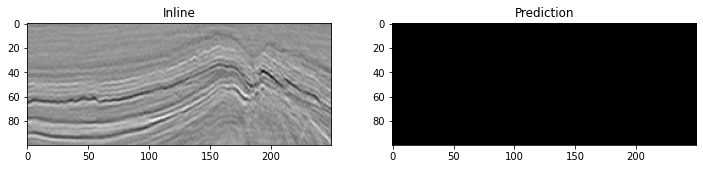

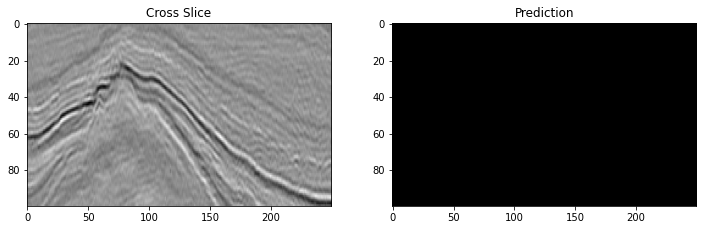

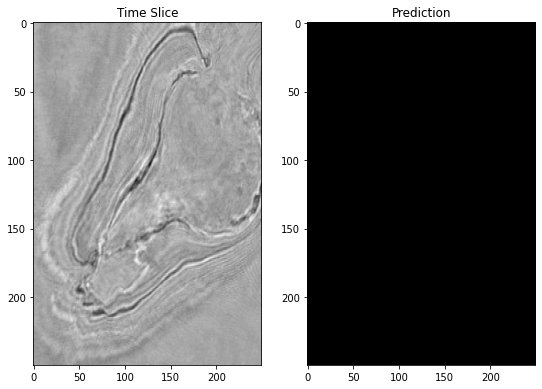

In [78]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from PIL import Image

k1,k2,k3 = 40,200,50   
gx1 = data[k1,:,:]
gy1 = class_cube[0][k1,:,:]
gx2 = data[:,k2,:]
gy2 = class_cube[0][:,k2,:]
gx3 = data[:,:,k3]
gy3 = class_cube[0][:,:,k3]

#Inline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
plt.title("Inline")
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.title("Prediction")

#Crossline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
plt.title("Cross Slice")
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.title("Prediction")

#Time slice
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
plt.title("Time Slice")
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.title("Prediction")
plt.show()

## 3D Volume Visualisation using pyvista

To visualize 3D volume of the detected salt we need to convert our 'cloud of points' to more graphical friendly representation.
For that we convert the points to voxels using PVGeo filters.

In [80]:
!pip install ipympl

     |████████████████████████████████| 106 kB 23.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [81]:
import pyvista as pv
import PVGeo

from PVGeo.filters import VoxelizePoints
%matplotlib widget
pv.set_plot_theme('document')

points = np.argwhere(class_cube[0] > 0.5)

print('Voxelizing...')

vtkpoints = PVGeo.points_to_poly_data(points)
voxelizer = PVGeo.filters.VoxelizePoints()
salt_voxels = voxelizer.apply(vtkpoints)
salt_voxels['elevation'] = points[:,:]

print('Done...')

Voxelizing...
ERROR: In /vtk/src/Filters/Python/vtkPythonAlgorithm.cxx, line 112
vtkPythonAlgorithm (0x5583b1755d10): Failure when calling method: "ProcessRequest":


Done...


In [82]:
salt = salt_voxels.extract_geometry() 

grid = pv.UniformGrid()
grid_values = data[:,:,:]
grid.dimensions = np.array(grid_values.shape)+ 1
grid.cell_arrays["values"] = grid_values.flatten(order="F")

plotter = pv.Plotter()

outline = grid.outline()

plotter.add_mesh(grid, name='volume',show_edges=False, cmap="Greys", opacity=0.25)
plotter.add_mesh(salt, show_edges=False, color="487DBE", show_scalar_bar=False)
plotter.add_mesh(outline, color='black')
plotter.add_axes()

plotter.show()

ValueError: Empty meshes cannot be plotted. Input mesh has zero points.